In [176]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

## Initial data preparation

In [177]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///F24.ML.Assignment.One.data.db')

with session_engine.connect() as conn: 
    data = pd.read_sql_query(text("""
    SELECT
        oh.order_id,
        oh.STATUS_ID,
        oh.planned_prep_time,
        oh.DATE_CREATE as order_created,
        opt.order_start_prepare,
        opt.order_ready,
        opt.region_id,
        ob.store_id,
        COUNT(ob.product_id) AS products_count,
        SUM(ob.price) AS total_price,
        opt.profit
    FROM order_history oh 
    NATURAL JOIN (SELECT 
            opv.order_id,
            MAX(CASE WHEN opv.ORDER_PROPS_ID = 11 THEN opv.VALUE END) AS region_id,
            MAX(CASE WHEN opv.ORDER_PROPS_ID = 97 THEN opv.VALUE END) AS order_start_prepare,
            MAX(CASE WHEN opv.ORDER_PROPS_ID = 95 THEN opv.VALUE END) AS order_ready,
            MAX(CASE WHEN opv.ORDER_PROPS_ID = 77 THEN opv.VALUE END) AS profit
        FROM order_props_value opv INNER JOIN order_props op 
            ON opv.ORDER_PROPS_ID == op.ID
        GROUP BY order_id) opt
    NATURAL JOIN order_busket ob
    GROUP BY order_id;
    """), conn) 

data.head()

,order_id,STATUS_ID,planned_prep_time,order_created,order_start_prepare,order_ready,region_id,store_id,products_count,total_price,profit
0,18671223,F,35.0,2024-05-08 00:01:12,2024-05-08 00:01:21,2024-05-08 00:25:12,683,3750,3,40.290,20.145
1,18671225,F,15.0,2024-05-08 00:01:46,2024-05-08 00:02:01,2024-05-08 00:10:29,703,5863,1,31.600,15.8
2,18671227,F,20.0,2024-05-08 00:01:38,2024-05-08 00:01:50,2024-05-08 00:49:19,691,8721,1,30.020,6.0040000000000004
3,18671229,F,30.0,2024-05-08 00:02:59,2024-05-08 00:10:07,2024-05-08 00:22:04,683,8929,4,80.580,40.29
4,18671231,F,25.0,2024-05-08 00:02:22,2024-05-08 00:02:37,2024-05-08 00:36:25,707,9007,3,153.418,122.73440000000001


In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             517610 non-null  int64  
 1   STATUS_ID            517610 non-null  object 
 2   planned_prep_time    517609 non-null  float64
 3   order_created        517337 non-null  object 
 4   order_start_prepare  465814 non-null  object 
 5   order_ready          466244 non-null  object 
 6   region_id            517610 non-null  object 
 7   store_id             517610 non-null  int64  
 8   products_count       517610 non-null  int64  
 9   total_price          502626 non-null  float64
 10  profit               466225 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 43.4+ MB


We can see that there are some columns with missing values. Let's count how much values are missing:

In [179]:
data.isna().sum()

order_id                   0
STATUS_ID                  0
planned_prep_time          1
order_created            273
order_start_prepare    51796
order_ready            51366
region_id                  0
store_id                   0
products_count             0
total_price            14984
profit                 51385
dtype: int64

Some of this values might be just dropped (e.g., planned_prep_time and order_created), other columns have too much missing values. I will try to preserve as much data as possible, but firstly - let's check numbers of unique values in categorical features:

In [180]:
categorical = ['products_count', 'region_id', 'store_id', 'STATUS_ID']
for column in categorical:
    print(f'{column}: {data[column].nunique()} unique values')

products_count: 26 unique values
region_id: 13 unique values
store_id: 1419 unique values
STATUS_ID: 2 unique values


Let's remove 'order_id' since it's not useful feature for our models:

In [181]:
data.drop(columns=['order_id'], axis=1, inplace=True)

Now let's address some columns that are considered 'objects' (or strings). 'region_id' should be the same type as the 'store_id' - numeric, or integer. Let's also encode 'STATUS_ID':

In [182]:
data['STATUS_ID'].value_counts()

STATUS_ID
F    517504
C       106
Name: count, dtype: int64

Based on the amount of F and C, I assume that F stands for 'fulfilled', and C - 'cancelled' As such, I decided to encode them as 'F' -> 1, 'C' -> 0:

In [183]:
data['region_id'] = data['region_id'].map(int)
data['STATUS_ID'] = data['STATUS_ID'].replace({'F': 1, 'C': 0})

Now, let's drop rows with missing values in the columns 'planned_prep_time' and 'order_created' and calculate how much of the original data is preserved:

In [184]:
rows_before = data.shape[0]
data = data.dropna(subset=['planned_prep_time', 'order_created'])
rows_after = data.shape[0]
print(f'Remaining data: {rows_after / rows_before * 100:.4f}%')

Remaining data: 99.9471%


Now let's address the columns that can be considered as 'datetime'. Here the format is 'mixed' because there can be values of different formats, e.g. %H:%M:%S and %H:%M are considered to be different formats:

In [185]:
data['order_created'] = pd.to_datetime(data['order_created'], format='mixed')
data['order_start_prepare'] = pd.to_datetime(data['order_start_prepare'], format='mixed')
data['order_ready'] = pd.to_datetime(data['order_ready'], format='mixed')

In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517336 entries, 0 to 517609
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   STATUS_ID            517336 non-null  int64         
 1   planned_prep_time    517336 non-null  float64       
 2   order_created        517336 non-null  datetime64[ns]
 3   order_start_prepare  465568 non-null  datetime64[ns]
 4   order_ready          465996 non-null  datetime64[ns]
 5   region_id            517336 non-null  int64         
 6   store_id             517336 non-null  int64         
 7   products_count       517336 non-null  int64         
 8   total_price          502358 non-null  float64       
 9   profit               465979 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(1)
memory usage: 43.4+ MB


Right, we have some missing values in 'order_start_prepare' and 'order_ready'. I'll address the latter later, for now let's focus on 'order_start_prepare'. Based on the names of the columns, we're handling data either from some restaurants or stores. Based on that and the fact that we have three columns: 'order_created', 'order_start_prepare' and 'store_id', we can assume that each store have their own average time passed from when the order was created and when it was started preparing. Let's find such mean values for each store, and then we'll change all missing values in 'order_start_prepare' for 'order_created' + mean time difference for the relevant store. To prevent any potential data leaks, I'll split the data and find meann time difference for each store in training set. If I encounter any 'store_id' that was not in the training set and have missing values in 'order_start_prepare' - I won't change it's value

In [187]:
X_train, X_test = train_test_split(data, test_size=0.1, shuffle=False, random_state=42)

In [188]:
store_ids = X_train['store_id'].unique()

In [189]:
X_train['time_diff_osp_oc'] = X_train['order_start_prepare'] - X_train['order_created']
mean_timediff_by_store = X_train.groupby('store_id')['time_diff_osp_oc'].mean().round('s')
X_train.drop(axis=1, columns='time_diff_osp_oc', inplace=True)
X_train['order_start_prepare'] = X_train.apply(lambda row: row['order_created'] + mean_timediff_by_store[row['store_id']] 
    if pd.isna(row['order_start_prepare']) else row['order_start_prepare'], axis=1)
X_test['order_start_prepare'] = X_test.apply(lambda row: row['order_created'] + mean_timediff_by_store[row['store_id']] 
    if pd.isna(row['order_start_prepare']) and row['store_id'] in store_ids else row['order_start_prepare'], axis=1)

In [190]:
X_test.isna().sum()

STATUS_ID                 0
planned_prep_time         0
order_created             0
order_start_prepare      26
order_ready            5113
region_id                 0
store_id                  0
products_count            0
total_price            1488
profit                 5112
dtype: int64

Now we have only 26 missing 'order_start_prepare' in testing set. We can just drop them

In [191]:
X_test.dropna(subset=['order_start_prepare'], inplace=True)

In [192]:
X_test.isna().sum()

STATUS_ID                 0
planned_prep_time         0
order_created             0
order_start_prepare       0
order_ready            5111
region_id                 0
store_id                  0
products_count            0
total_price            1487
profit                 5109
dtype: int64

Great. Now let's concatenate our data for ease of subsequent preparation

In [193]:
data = pd.concat([X_train, X_test])

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517310 entries, 0 to 517609
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   STATUS_ID            517310 non-null  int64         
 1   planned_prep_time    517310 non-null  float64       
 2   order_created        517310 non-null  datetime64[ns]
 3   order_start_prepare  517308 non-null  datetime64[ns]
 4   order_ready          465972 non-null  datetime64[ns]
 5   region_id            517310 non-null  int64         
 6   store_id             517310 non-null  int64         
 7   products_count       517310 non-null  int64         
 8   total_price          502333 non-null  float64       
 9   profit               465956 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(1)
memory usage: 43.4+ MB


As we can see, it worked, and we have only two missing values left. Let's drop them:

In [195]:
data.dropna(subset='order_start_prepare', inplace=True)
rows_after = data.shape[0]
print(f'Remaining data: {rows_after / rows_before * 100:.4f}%')

Remaining data: 99.9417%


In [196]:
data.isna().sum()

STATUS_ID                  0
planned_prep_time          0
order_created              0
order_start_prepare        0
order_ready            51338
region_id                  0
store_id                   0
products_count             0
total_price            14977
profit                 51353
dtype: int64

Now let's address the missing values in 'order_ready'. For this I'll implement a regression model for predicting the value based on other two datetime columns (as to prevent data leakage from other features). I would divide my data on clean (without missing values in 'order_ready') and missing (only rows with missing values in 'order_ready'), then I'll divide clean data for training and testing set, and if my regressor is good, I'll use it to predict points for missing data.

In [197]:
data_clean = data.dropna(subset='order_ready')
data_missing = data.loc[data['order_ready'].isna()]

X = data_clean[['order_created', 'order_start_prepare']]
y = data_clean['order_ready']

In [198]:
X.loc[:,'order_created'] = pd.to_numeric(X['order_created'])
X.loc[:,'order_start_prepare'] = pd.to_numeric(X['order_start_prepare'])
y = pd.to_numeric(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

MSE: 6.47601966791414e+23
MAE: 594714527393.6969
R^2: 0.9999999276721561


As we can see, the regressor did a good job. MSE and MAE are rather large since we transformed datetime to numeric values (which are huge by itself). Determination coefficient is 0.9999..., this tells me that this regressor can be used to predict missing values.

In [199]:
X_missing = data_missing[['order_created', 'order_start_prepare']]
X_missing.loc[:,'order_created'] = pd.to_numeric(X_missing['order_created'])
X_missing.loc[:,'order_start_prepare'] = pd.to_numeric(X_missing['order_start_prepare'])

data_missing.loc[:,'order_ready'] = rfr.predict(X_missing)

In [200]:
data.loc[data_missing.index, 'order_ready'] = pd.to_datetime(data_missing['order_ready'])

In [201]:
data.isna().sum()

STATUS_ID                  0
planned_prep_time          0
order_created              0
order_start_prepare        0
order_ready                0
region_id                  0
store_id                   0
products_count             0
total_price            14977
profit                 51353
dtype: int64

Great, no more missing values there (ignote 'total_price' and 'profit' for now, I'll return to it later). Let's do some feature engineering. Both our tasks (regression and classification) require us to find actual preparation time: how long does it take to prepare that order.

In [202]:
data['actual_preparation_time'] = data['order_ready'] - data['order_start_prepare']

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517308 entries, 0 to 517609
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   STATUS_ID                517308 non-null  int64          
 1   planned_prep_time        517308 non-null  float64        
 2   order_created            517308 non-null  datetime64[ns] 
 3   order_start_prepare      517308 non-null  datetime64[ns] 
 4   order_ready              517308 non-null  datetime64[ns] 
 5   region_id                517308 non-null  int64          
 6   store_id                 517308 non-null  int64          
 7   products_count           517308 non-null  int64          
 8   total_price              502331 non-null  float64        
 9   profit                   465955 non-null  object         
 10  actual_preparation_time  517308 non-null  timedelta64[ns]
dtypes: datetime64[ns](3), float64(2), int64(4), object(1), timedelta64[ns]

In [204]:
data['order_start_prepare'] = pd.to_datetime(data['order_start_prepare'], format='mixed')
data['order_created'] = pd.to_datetime(data['order_created'], format='mixed')

Seems good, right? But what if we had some issues with our data? For example, what if someone put wrong values in order_start_prepare and/or order_ready? This potentially could lead to the situation where actual preparation time is negative. Let's check for that:

In [205]:
negative_timedeltas = data[data['actual_preparation_time'] <= pd.Timedelta(0)]
len(negative_timedeltas)

2394

It seems that we have some values that are negative. We could potentially swap the 'order_start_prepare' and 'order_ready' for that values, but I think that it's not that much of the data, so let's drop it as well:

In [206]:
data = data[data['actual_preparation_time'] > pd.Timedelta(0)]
rows_after = data.shape[0]
print(f'Remaining data: {rows_after / rows_before * 100:.4f}%')

Remaining data: 99.4791%


In total, we deleted only ~0.52% of the data, which is not bad, considering we've had more than 517k of rows. Now let's transform our 'actual_preparation_time' from timedelta to number of minutes in other data type:

In [207]:
data['actual_preparation_time'] = data['actual_preparation_time'].apply(lambda value: value.total_seconds() // 60)
data.head()

,STATUS_ID,planned_prep_time,order_created,order_start_prepare,order_ready,region_id,store_id,products_count,total_price,profit,actual_preparation_time
0,1,35.0,2024-05-08 00:01:12,2024-05-08 00:01:21,2024-05-08 00:25:12,683,3750,3,40.290,20.145,23.0
1,1,15.0,2024-05-08 00:01:46,2024-05-08 00:02:01,2024-05-08 00:10:29,703,5863,1,31.600,15.8,8.0
2,1,20.0,2024-05-08 00:01:38,2024-05-08 00:01:50,2024-05-08 00:49:19,691,8721,1,30.020,6.0040000000000004,47.0
3,1,30.0,2024-05-08 00:02:59,2024-05-08 00:10:07,2024-05-08 00:22:04,683,8929,4,80.580,40.29,11.0
4,1,25.0,2024-05-08 00:02:22,2024-05-08 00:02:37,2024-05-08 00:36:25,707,9007,3,153.418,122.73440000000001,33.0


Now let's extract more features from our datetime columns (apart from order_ready: I assume that we won't know this value and we would use that model to better predict planned_prep_time). It is clear that we can get year, month, day, weekday, hour, minute and seconds. We also can determine whether the day is weekend or not:

In [208]:
# Extracting features from order_created
data['oc_year'] = data['order_created'].dt.year
data['oc_month'] = data['order_created'].dt.month
data['oc_day'] = data['order_created'].dt.day
data['oc_weekday'] = data['order_created'].dt.weekday
data['oc_hour'] = data['order_created'].dt.hour
data['oc_minute'] = data['order_created'].dt.minute
data['oc_second'] = data['order_created'].dt.second

# Extracting features from order_start_prepare
data['osp_year'] = data['order_start_prepare'].dt.year
data['osp_month'] = data['order_start_prepare'].dt.month
data['osp_day'] = data['order_start_prepare'].dt.day
data['osp_weekday'] = data['order_start_prepare'].dt.weekday
data['osp_hour'] = data['order_start_prepare'].dt.hour
data['osp_minute'] = data['order_start_prepare'].dt.minute
data['osp_second'] = data['order_start_prepare'].dt.second

# Additional features
data['oc_is_weekend'] = data['oc_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
data['osp_is_weekend'] = data['osp_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

data.drop(columns=['order_created', 'order_start_prepare', 'order_ready'], inplace=True)

Now let's check how many years of data do we have: perhaps, it's only 1 year, then we won't need that information

In [209]:
years = ['oc_year', 'osp_year']
for column in years:
    print(f'{column}: {data[column].unique()}')

oc_year: [2024]
osp_year: [2024]


As we can see, it's constant. Let's remove it from our data

In [210]:
data.drop(columns=years, inplace=True)

Now let's get one last feature: whether order was prepared in time or not. The order was prepared in time if the absolute difference between planned and actual preparation time does not exceed 5 minutes:

In [211]:
data['prepared_in_time'] = ((data['planned_prep_time'] - data['actual_preparation_time']).abs() <= 5).map(int)

Now let's split the data and tend to the remaining missing values. I would divide the data as for the regression problem, although at that stage it's not imperative:

In [212]:
X = data.drop('actual_preparation_time', axis=1)
y = data['actual_preparation_time']

X_train, X_test = train_test_split(X, test_size=0.1, shuffle=False)

X_train.shape, X_test.shape

((463422, 22), (51492, 22))

Next I would encode the categorical data which is not yet encoded, such as region_id and store_id, and then use SimpleImputer to impute the missing values. I would train both OrdinalEncoder and SimpleImputer on training set to prevent any data leaks

In [213]:
region_encoder = OrdinalEncoder()
region_encoder.fit(X_train[['region_id']])
X_train['region_id'] = region_encoder.transform(X_train[['region_id']])
X_test['region_id'] = region_encoder.transform(X_test[['region_id']])


store_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
store_encoder.fit(X_train[['store_id']])
X_train['store_id'] = store_encoder.transform(X_train[['store_id']])
X_test['store_id'] = store_encoder.transform(X_test[['store_id']])


imputer = SimpleImputer()
imputer.fit(X_train)
X_train_impute = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_impute = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [214]:
X_train_impute.head()

,STATUS_ID,planned_prep_time,region_id,store_id,products_count,total_price,profit,oc_month,oc_day,oc_weekday,...,oc_second,osp_month,osp_day,osp_weekday,osp_hour,osp_minute,osp_second,oc_is_weekend,osp_is_weekend,prepared_in_time
0,1.0,35.0,0.0,119.0,3.0,40.290,20.1450,5.0,8.0,2.0,...,12.0,5.0,8.0,2.0,0.0,1.0,21.0,0.0,0.0,0.0
1,1.0,15.0,8.0,370.0,1.0,31.600,15.8000,5.0,8.0,2.0,...,46.0,5.0,8.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0
2,1.0,20.0,4.0,667.0,1.0,30.020,6.0040,5.0,8.0,2.0,...,38.0,5.0,8.0,2.0,0.0,1.0,50.0,0.0,0.0,0.0
3,1.0,30.0,0.0,695.0,4.0,80.580,40.2900,5.0,8.0,2.0,...,59.0,5.0,8.0,2.0,0.0,10.0,7.0,0.0,0.0,0.0
4,1.0,25.0,10.0,704.0,3.0,153.418,122.7344,5.0,8.0,2.0,...,22.0,5.0,8.0,2.0,0.0,2.0,37.0,0.0,0.0,0.0


For the sake of not doing whole preparation again and because we were not shuffling the data I would concatenate training and testing sets and return the actual_preparation_time to the dataframe in order to save it

In [215]:
X_concat = pd.concat([X_train_impute, X_test_impute])
X_concat['actual_preparation_time'] = y

In [216]:
X_concat.to_csv('data_preprocessed.csv')

## Data preparation and EDA

In [217]:
df = pd.read_csv('data_preprocessed.csv', index_col=0)
df.head()

,STATUS_ID,planned_prep_time,region_id,store_id,products_count,total_price,profit,oc_month,oc_day,oc_weekday,...,osp_month,osp_day,osp_weekday,osp_hour,osp_minute,osp_second,oc_is_weekend,osp_is_weekend,prepared_in_time,actual_preparation_time
0,1.0,35.0,0.0,119.0,3.0,40.290,20.1450,5.0,8.0,2.0,...,5.0,8.0,2.0,0.0,1.0,21.0,0.0,0.0,0.0,23.0
1,1.0,15.0,8.0,370.0,1.0,31.600,15.8000,5.0,8.0,2.0,...,5.0,8.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,8.0
2,1.0,20.0,4.0,667.0,1.0,30.020,6.0040,5.0,8.0,2.0,...,5.0,8.0,2.0,0.0,1.0,50.0,0.0,0.0,0.0,47.0
3,1.0,30.0,0.0,695.0,4.0,80.580,40.2900,5.0,8.0,2.0,...,5.0,8.0,2.0,0.0,10.0,7.0,0.0,0.0,0.0,11.0
4,1.0,25.0,10.0,704.0,3.0,153.418,122.7344,5.0,8.0,2.0,...,5.0,8.0,2.0,0.0,2.0,37.0,0.0,0.0,0.0,33.0


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514914 entries, 0 to 517609
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   STATUS_ID                514914 non-null  float64
 1   planned_prep_time        514914 non-null  float64
 2   region_id                514914 non-null  float64
 3   store_id                 514914 non-null  float64
 4   products_count           514914 non-null  float64
 5   total_price              514914 non-null  float64
 6   profit                   514914 non-null  float64
 7   oc_month                 514914 non-null  float64
 8   oc_day                   514914 non-null  float64
 9   oc_weekday               514914 non-null  float64
 10  oc_hour                  514914 non-null  float64
 11  oc_minute                514914 non-null  float64
 12  oc_second                514914 non-null  float64
 13  osp_month                514914 non-null  float64
 14  osp_day  

In [219]:
df.isna().sum()

STATUS_ID                  0
planned_prep_time          0
region_id                  0
store_id                   0
products_count             0
total_price                0
profit                     0
oc_month                   0
oc_day                     0
oc_weekday                 0
oc_hour                    0
oc_minute                  0
oc_second                  0
osp_month                  0
osp_day                    0
osp_weekday                0
osp_hour                   0
osp_minute                 0
osp_second                 0
oc_is_weekend              0
osp_is_weekend             0
prepared_in_time           0
actual_preparation_time    0
dtype: int64

As we can see, our data is clean and only have numeric values. Keep in mind that every '*_id' is encoded. Let's get some descriptive statistics of our data

In [220]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
STATUS_ID,514914.0,0.999852,0.012148,0.0000,1.0000,1.00,1.00,1.000
planned_prep_time,514914.0,23.290678,8.273876,0.0000,20.0000,20.00,30.00,180.000
region_id,514914.0,3.569462,4.178815,0.0000,0.0000,1.00,8.00,12.000
store_id,514914.0,470.241343,354.107476,-1.0000,160.0000,397.00,728.00,1382.000
products_count,514914.0,2.612275,1.569533,1.0000,1.0000,2.00,3.00,31.000
total_price,514914.0,80.301364,63.622503,4.0290,39.5000,65.57,99.54,2007.390
profit,514914.0,43.281631,41.054876,0.8216,17.1825,34.76,52.14,1605.912
oc_month,514914.0,6.686959,1.155906,5.0000,6.0000,7.00,8.00,9.000
oc_day,514914.0,16.128274,8.838592,1.0000,9.0000,16.00,24.00,31.000
oc_weekday,514914.0,3.025870,1.976597,0.0000,1.0000,3.00,5.00,6.000


There are a lot of features that we inferred from the datetimes. Let's make a list with names of the columns, as well as lists of columns withoud datetime features and columns for pairplot (without categorical features)

In [221]:
columns_datetime_features = ['oc_month', 'oc_day', 'oc_weekday', 'oc_hour', 'oc_minute', 'oc_second',
    'osp_month', 'osp_day', 'osp_weekday', 'osp_hour', 'osp_minute', 'osp_second']

In [222]:
columns_without_datetime = [x for x in df.columns if x not in columns_datetime_features]
columns_without_datetime.remove('oc_is_weekend')
columns_without_datetime.remove('osp_is_weekend')
columns_without_datetime

['STATUS_ID',
 'planned_prep_time',
 'region_id',
 'store_id',
 'products_count',
 'total_price',
 'profit',
 'prepared_in_time',
 'actual_preparation_time']

<Figure size 1000x800 with 0 Axes>

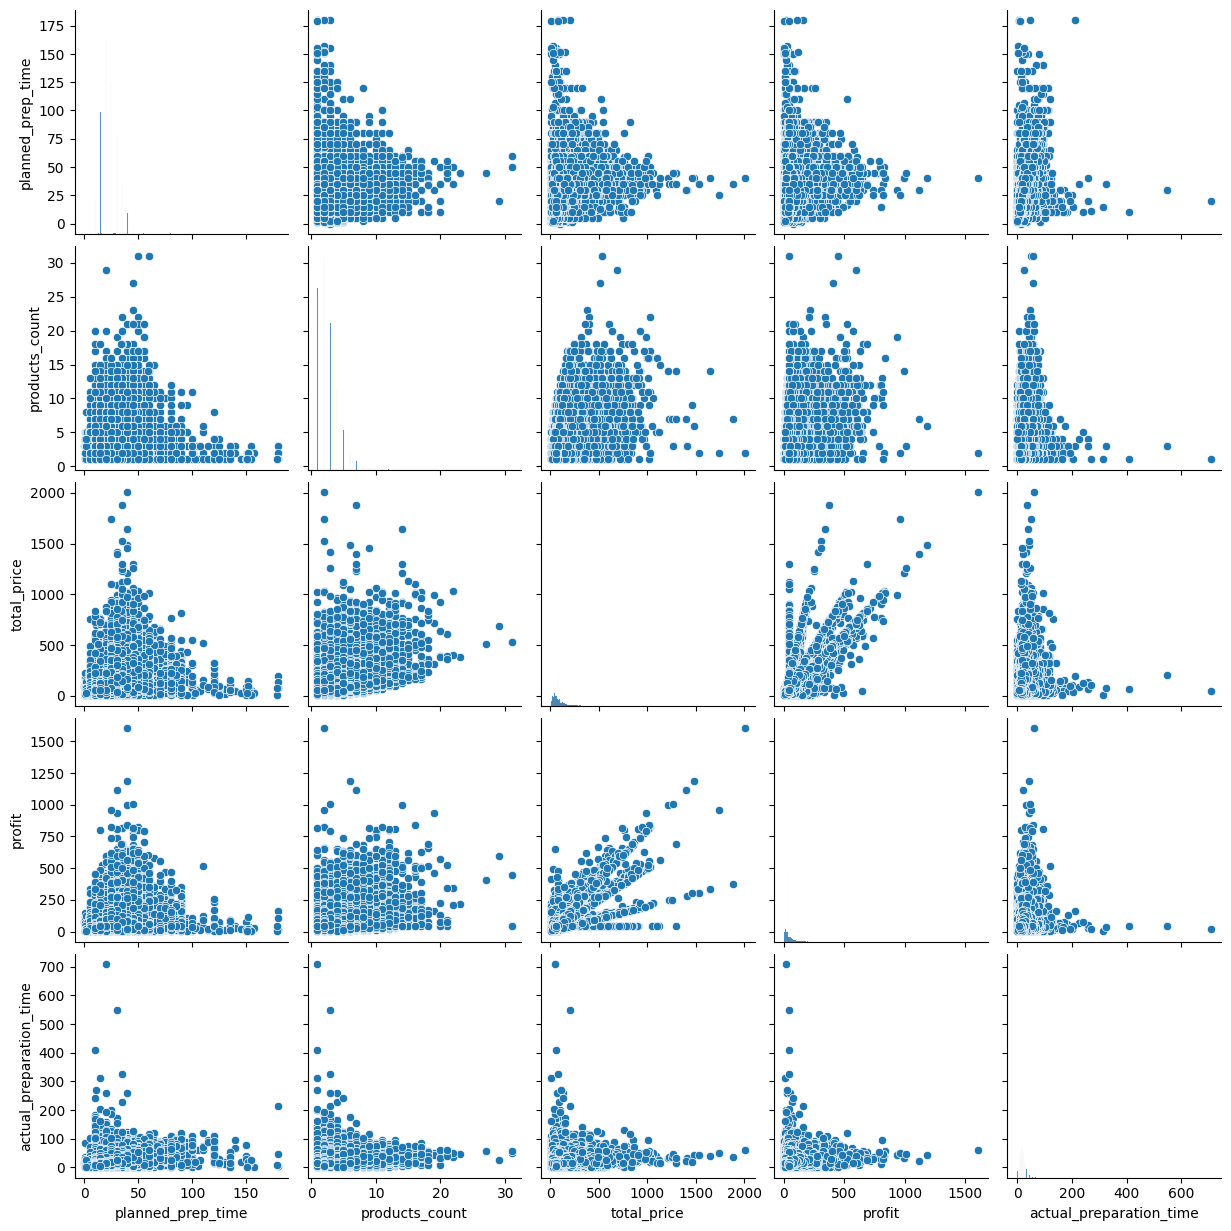

In [223]:
cols_for_pairplot = columns_without_datetime.copy()
cols_for_pairplot.remove('STATUS_ID')
cols_for_pairplot.remove('region_id')
cols_for_pairplot.remove('store_id')
cols_for_pairplot.remove('prepared_in_time')

plt.figure(figsize=(10, 8))
sns.pairplot(df[cols_for_pairplot])
plt.show()

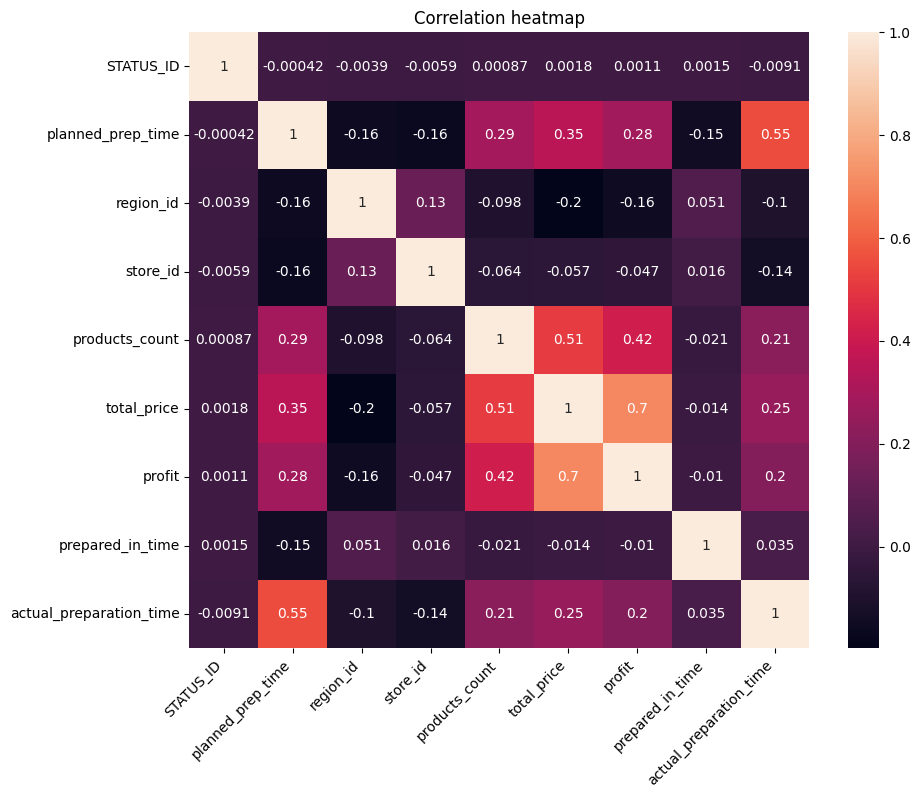

In [224]:
plt.figure(figsize=(10, 8))
plt.title('Correlation heatmap')
sns.heatmap(df[columns_without_datetime].corr(), annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

There are 5 columns with potential outliers: 'planned_prep_time', 'products_count', 'profit', 'total_price' and 'actual_preparation_time'. Let's take a closer look at them

<Figure size 1500x500 with 0 Axes>

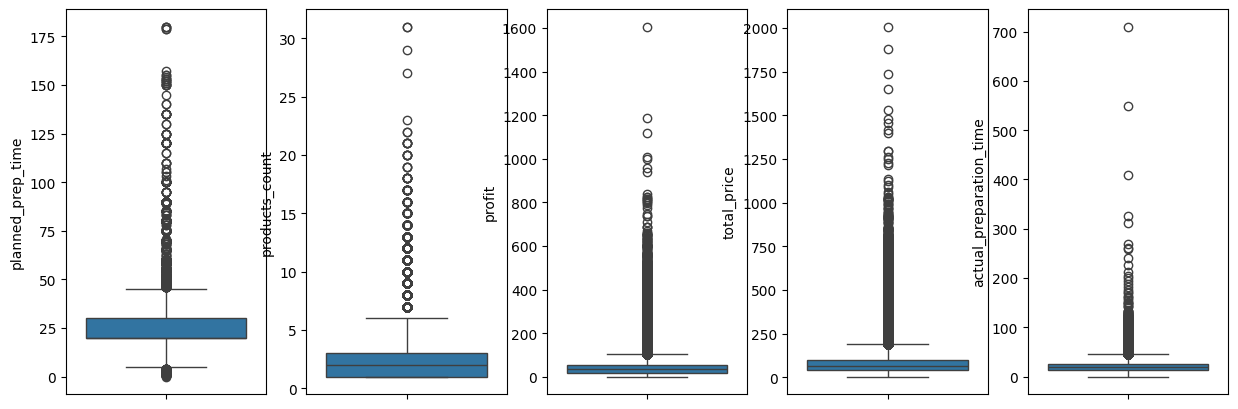

In [225]:
potential_outliers_columns = ['planned_prep_time', 'products_count', 'profit', 'total_price', 'actual_preparation_time']

plt.figure(figsize=(15, 5))
fig, axes = plt.subplots(1, len(potential_outliers_columns), figsize=(15,5))
for i, col in enumerate(potential_outliers_columns):
    sns.boxplot(y=df[col], ax=axes[i])

Yes, there are some outliers. Let's not do anything about them for now and do this in the classification task. 

Let's encode every feature extracted from datetime with sine and cosine to capture the cyclical nature of these features:

In [226]:
def encode_cyclical(value, max_value):
    sin_encoded = np.sin(2 * np.pi * value / max_value)
    cos_encoded = np.cos(2 * np.pi * value / max_value)
    return sin_encoded, cos_encoded

In [227]:
for col in columns_datetime_features:
    sin_encoded, cos_encoded = encode_cyclical(df[col], df[col].max())
    df[f'{col}_sin'] = sin_encoded
    df[f'{col}_cos'] = cos_encoded
    df.drop(columns=[col], inplace=True)

df

,STATUS_ID,planned_prep_time,region_id,store_id,products_count,total_price,profit,oc_is_weekend,osp_is_weekend,prepared_in_time,...,osp_day_sin,osp_day_cos,osp_weekday_sin,osp_weekday_cos,osp_hour_sin,osp_hour_cos,osp_minute_sin,osp_minute_cos,osp_second_sin,osp_second_cos
0,1.0,35.0,0.0,119.0,3.0,40.290,20.1450,0.0,0.0,0.0,...,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.106293,0.994335,0.786552,-0.617525
1,1.0,15.0,8.0,370.0,1.0,31.600,15.8000,0.0,0.0,0.0,...,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.211383,0.977403,0.106293,0.994335
2,1.0,20.0,4.0,667.0,1.0,30.020,6.0040,0.0,0.0,0.0,...,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.106293,0.994335,-0.818303,0.574787
3,1.0,30.0,0.0,695.0,4.0,80.580,40.2900,0.0,0.0,0.0,...,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.874763,0.484551,0.678312,0.734774
4,1.0,25.0,10.0,704.0,3.0,153.418,122.7344,0.0,0.0,0.0,...,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.211383,0.977403,-0.716457,-0.697632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517605,1.0,15.0,10.0,485.0,1.0,22.120,11.0600,0.0,0.0,1.0,...,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.847734,-0.530421,0.971430,-0.237327
517606,1.0,20.0,11.0,349.0,2.0,41.080,32.8640,0.0,0.0,1.0,...,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.899312,-0.437307,0.507666,0.861554
517607,1.0,20.0,0.0,1068.0,1.0,54.510,43.6080,0.0,0.0,0.0,...,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.638244,-0.769834,-0.999646,-0.026621
517608,1.0,10.0,0.0,132.0,2.0,60.672,30.3360,0.0,0.0,1.0,...,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.461093,-0.887352,0.899312,-0.437307


## Regression models

### With outliers

In [228]:
dfr = df.copy(deep=True)
dfr.drop(columns=['prepared_in_time'], inplace=True)
X_train, X_test = train_test_split(
    dfr.drop('actual_preparation_time', axis=1),
    test_size=0.1, shuffle=False)

y_train, y_test = train_test_split(dfr['actual_preparation_time'], test_size=0.1, shuffle=False)

X_train.shape

(463422, 33)

In [229]:
scaler = StandardScaler()
scaler.fit(X_train[['planned_prep_time', 'products_count', 'total_price', 'profit']])
X_train[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_train[['planned_prep_time', 'products_count', 'total_price', 'profit']])
X_test[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_test[['planned_prep_time', 'products_count', 'total_price', 'profit']])

In [230]:
def regression_scores(y_true, y_pred, model_name):
    print(f'{model_name} Regression:')
    print(f' MSE: {mean_squared_error(y_true, y_pred)}')
    print(f' MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f' R^2: {r2_score(y_true, y_pred)}\n')
    
    eval_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
    x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
    plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
    plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

Linear Regression:
 MSE: 80.53050461160272
 MAE: 6.574442212832072
 R^2: 0.3018972400746537

Model intercept: 30.480644005327317
Model coefs: [-8.46872950e+00  5.74616229e+00 -1.13254049e-02 -1.56401569e-03
  3.92461038e-01  5.13653063e-01  8.52170920e-02  1.71681587e+00
 -1.73400697e+00  5.92449912e-01  6.86439997e+00 -3.50430711e+00
 -3.56582407e+00  1.09677285e-01  2.82585118e-01 -1.00909692e-01
  3.42459271e-01  3.16760089e-03  7.63338131e-02 -4.71059348e-03
  3.36979406e-01 -2.05844193e-01 -6.80753455e+00  3.50849712e+00
  3.52180808e+00 -2.35983420e-01 -3.17411841e-01  4.88243136e-01
 -3.01768503e-01 -8.78129308e-03 -8.43773839e-02 -6.75890795e-02
 -5.85467270e-02]


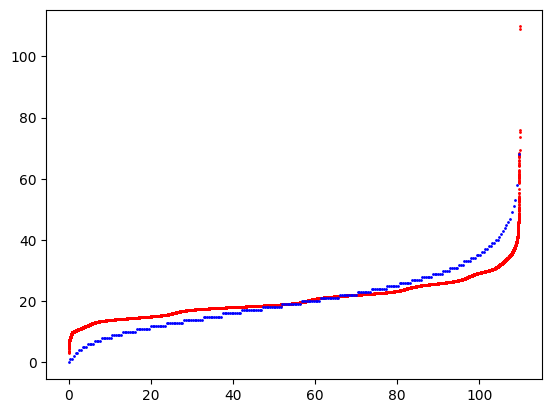

In [231]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

regression_scores(y_test, lr_preds, 'Linear')

print(f'Model intercept: {lr.intercept_}')
print(f'Model coefs: {lr.coef_}')

Best alpha: 1e-06
Ridge (alpha=1e-06) Regression:
 MSE: 80.53050461209128
 MAE: 6.574442212833169
 R^2: 0.3018972400704185

Model intercept: 30.480643851578154
Model coefs: [-8.46872935e+00  5.74616229e+00 -1.13254049e-02 -1.56401569e-03
  3.92461038e-01  5.13653063e-01  8.52170920e-02  1.71681590e+00
 -1.73400700e+00  5.92450174e-01  6.86439607e+00 -3.50430571e+00
 -3.56582339e+00  1.09677194e-01  2.82585114e-01 -1.00909692e-01
  3.42459268e-01  3.16760149e-03  7.63338133e-02 -4.71059349e-03
  3.36979406e-01 -2.05844455e-01 -6.80753065e+00  3.50849572e+00
  3.52180740e+00 -2.35983329e-01 -3.17411837e-01  4.88243135e-01
 -3.01768500e-01 -8.78129373e-03 -8.43773842e-02 -6.75890795e-02
 -5.85467270e-02]


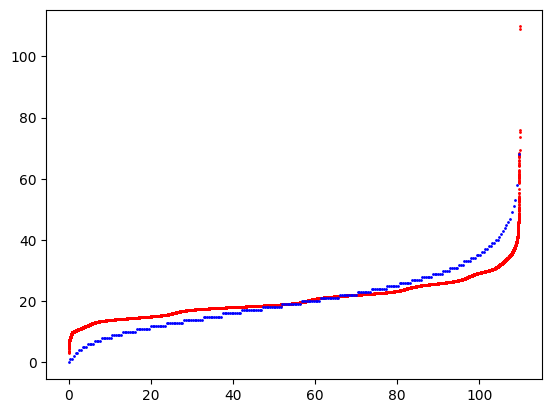

In [232]:
alphas = np.linspace(0.000001, 1, 500)

mses_ridge, maes_ridge, r2s_ridge = [], [], []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_preds = ridge.predict(X_test)
    mses_ridge.append(mean_squared_error(y_test, ridge_preds))
    maes_ridge.append(mean_absolute_error(y_test, ridge_preds))
    r2s_ridge.append(r2_score(y_test, ridge_preds))

best_alpha = alphas[np.argmax(r2s_ridge)]

print(f'Best alpha: {best_alpha}')

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

ridge_preds = ridge.predict(X_test)

regression_scores(y_test, ridge_preds, f'Ridge (alpha={best_alpha})')

print(f'Model intercept: {ridge.intercept_}')
print(f'Model coefs: {ridge.coef_}')

Best depth: 7
Decision Tree Regression:
 MSE: 79.13818965727332
 MAE: 6.498729789038444
 R^2: 0.3139669385943703



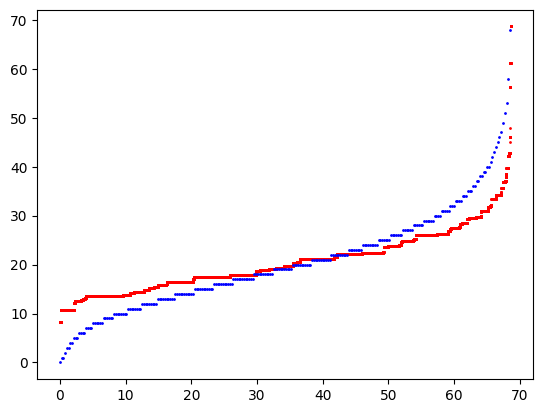

In [233]:
depths = range(2, 25)

mses_dtr, maes_dtr, r2s_dtr = [], [], []

for depth in depths:
    dtr = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
    dtr_preds = dtr.predict(X_test)
    mses_dtr.append(mean_squared_error(y_test, dtr_preds))
    maes_dtr.append(mean_absolute_error(y_test, dtr_preds))
    r2s_dtr.append(r2_score(y_test, dtr_preds))

best_depth = depths[np.argmax(r2s_dtr)]

print(f'Best depth: {best_depth}')

dtr = DecisionTreeRegressor(max_depth=best_depth)
dtr.fit(X_train, y_train)

dtr_preds = dtr.predict(X_test)

regression_scores(y_test, dtr_preds, 'Decision Tree')

In [234]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [235]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

model = RegressionModel(input_size=X_train.shape[1], hidden_size=20)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 25

mse_scores = []
mae_scores = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    model.eval()
    with torch.no_grad():
        nn_outputs = model(X_test_tensor)
        
        mse_scores.append(mean_squared_error(y_test_tensor.numpy(), nn_outputs.numpy()))
        mae_scores.append(mean_absolute_error(y_test_tensor.numpy(), nn_outputs.numpy()))
        r2_scores.append(r2_score(y_test_tensor.numpy(), nn_outputs.numpy()))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}\n MSE: {mse_scores[-1]:.4f}, MAE: {mae_scores[-1]:.4f}, R2: {r2_scores[-1]:.4f}')

Epoch [1/25], Loss: 71.2652
 MSE: 113.5270, MAE: 7.7462, R2: 0.0159
Epoch [2/25], Loss: 68.2088
 MSE: 106.0851, MAE: 7.4394, R2: 0.0804
Epoch [3/25], Loss: 60.6215
 MSE: 99.1524, MAE: 7.1611, R2: 0.1405
Epoch [4/25], Loss: 55.6658
 MSE: 88.8919, MAE: 6.7546, R2: 0.2294
Epoch [5/25], Loss: 54.4325
 MSE: 84.8781, MAE: 6.6226, R2: 0.2642
Epoch [6/25], Loss: 56.1037
 MSE: 83.1234, MAE: 6.5700, R2: 0.2794
Epoch [7/25], Loss: 56.3140
 MSE: 81.1849, MAE: 6.5353, R2: 0.2962
Epoch [8/25], Loss: 57.2305
 MSE: 81.1554, MAE: 6.5288, R2: 0.2965
Epoch [9/25], Loss: 56.5516
 MSE: 80.7663, MAE: 6.5265, R2: 0.2999
Epoch [10/25], Loss: 55.4503
 MSE: 80.8248, MAE: 6.5263, R2: 0.2993
Epoch [11/25], Loss: 56.5519
 MSE: 80.6398, MAE: 6.5274, R2: 0.3009
Epoch [12/25], Loss: 56.6701
 MSE: 80.7677, MAE: 6.5359, R2: 0.2998
Epoch [13/25], Loss: 56.2847
 MSE: 80.8147, MAE: 6.5180, R2: 0.2994
Epoch [14/25], Loss: 56.5469
 MSE: 80.7223, MAE: 6.5125, R2: 0.3002
Epoch [15/25], Loss: 57.4545
 MSE: 80.6280, MAE: 6.5093

Neural Network Regression:
 MSE: 80.48824078286061
 MAE: 6.516009134373205
 R^2: 0.30226361671208046



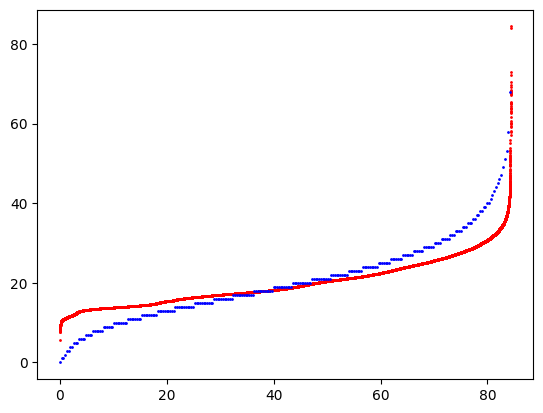

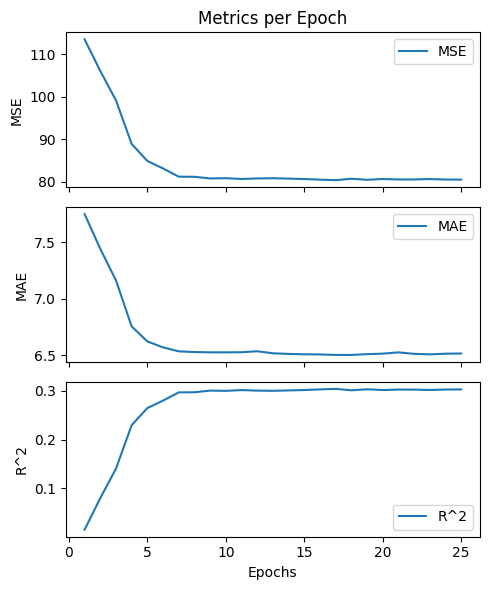

In [236]:
with torch.no_grad():
    nn_preds = model(X_test_tensor)

regression_scores(y_test, nn_preds.numpy().reshape(1, -1)[0], 'Neural Network')

epochs = range(1, len(mse_scores) + 1)

fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)

axes[0].plot(epochs, mse_scores, label='MSE')
axes[0].set_ylabel('MSE')
axes[0].set_title('Metrics per Epoch')
axes[0].legend()

axes[1].plot(epochs, mae_scores, label='MAE')
axes[1].set_ylabel('MAE')
axes[1].legend()

axes[2].plot(epochs, r2_scores, label='R^2')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('R^2')
axes[2].legend()

plt.tight_layout()
plt.show()

In [237]:
cat = CatBoostRegressor()
cat.fit(X_train, y_train)

Learning rate set to 0.107995
0:	learn: 10.7523457	total: 64.5ms	remaining: 1m 4s
1:	learn: 10.4615637	total: 121ms	remaining: 1m
2:	learn: 10.2256665	total: 179ms	remaining: 59.4s
3:	learn: 10.0300504	total: 236ms	remaining: 58.8s
4:	learn: 9.8707749	total: 291ms	remaining: 57.8s
5:	learn: 9.7422315	total: 345ms	remaining: 57.2s
6:	learn: 9.6350530	total: 406ms	remaining: 57.6s
7:	learn: 9.5509245	total: 466ms	remaining: 57.7s
8:	learn: 9.4819186	total: 546ms	remaining: 1m
9:	learn: 9.4231580	total: 603ms	remaining: 59.7s
10:	learn: 9.3724778	total: 662ms	remaining: 59.5s
11:	learn: 9.3324601	total: 716ms	remaining: 58.9s
12:	learn: 9.2974141	total: 771ms	remaining: 58.6s
13:	learn: 9.2690665	total: 832ms	remaining: 58.6s
14:	learn: 9.2464247	total: 898ms	remaining: 58.9s
15:	learn: 9.2264966	total: 950ms	remaining: 58.4s
16:	learn: 9.2110220	total: 1s	remaining: 57.8s
17:	learn: 9.1969523	total: 1.06s	remaining: 57.6s
18:	learn: 9.1855600	total: 1.11s	remaining: 57.2s
19:	learn: 9.17

CatBoost Regression:
 MSE: 75.12019845351669
 MAE: 6.322213010952978
 R^2: 0.34879809682722374



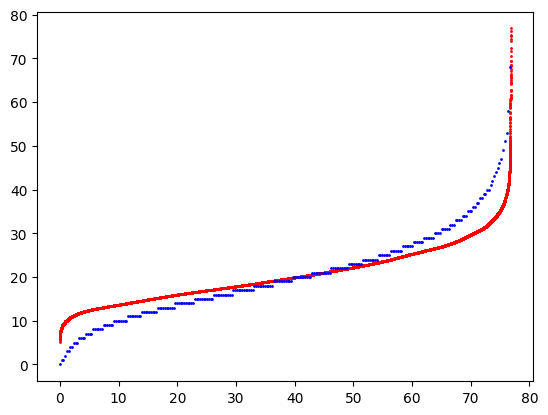

In [238]:
cat_preds = cat.predict(X_test)

regression_scores(y_test, cat_preds, 'CatBoost')

### Without outliers

In [239]:
dfr = df.copy(deep=True)
dfr.drop(columns=['prepared_in_time'], inplace=True)
potential_outliers_columns = ['planned_prep_time', 'products_count', 'total_price', 'profit']
X_train, X_test = train_test_split(
    dfr.drop('actual_preparation_time', axis=1),
    test_size=0.1, shuffle=False)

y_train, y_test = train_test_split(dfr['actual_preparation_time'], test_size=0.1, shuffle=False)

X_train.shape

(463422, 33)

In [240]:
Q1 = X_train[potential_outliers_columns].quantile(0.25)
Q3 = X_train[potential_outliers_columns].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_train = ((X_train[potential_outliers_columns] < lower_bound) | (X_train[potential_outliers_columns] > upper_bound)).any(axis=1)

X_train_clean = X_train[~outliers_train]
y_train_clean = y_train[~outliers_train]

outliers_test = ((X_test[potential_outliers_columns] < lower_bound) | (X_test[potential_outliers_columns] > upper_bound)).any(axis=1)

X_test_clean = X_test[~outliers_test]
y_test_clean = y_test[~outliers_test]

In [241]:
print(f'After IQR outlier detection and removal remains {X_train_clean.shape[0]} rows in X_train, or {X_train_clean.shape[0] / X_train.shape[0] * 100:.4f}% of original training data')
print(f'After IQR outlier detection and removal remains {X_test_clean.shape[0]} rows in X_test, or {X_test_clean.shape[0] / X_test.shape[0] * 100:.4f}% of original testing data')

After IQR outlier detection and removal remains 413624 rows in X_train, or 89.2543% of original training data
After IQR outlier detection and removal remains 45674 rows in X_test, or 88.7012% of original testing data


In [242]:
scaler = StandardScaler()
scaler.fit(X_train_clean[potential_outliers_columns])
X_train_clean[potential_outliers_columns] = scaler.transform(X_train_clean[potential_outliers_columns])
X_test_clean[potential_outliers_columns] = scaler.transform(X_test_clean[potential_outliers_columns])

/tmp/ipykernel_3884/4000422509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_clean[potential_outliers_columns] = scaler.transform(X_train_clean[potential_outliers_columns])
/tmp/ipykernel_3884/4000422509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_clean[potential_outliers_columns] = scaler.transform(X_test_clean[potential_outliers_columns])


Linear Regression:
 MSE: 78.0106454866296
 MAE: 6.487559697107778
 R^2: 0.24971801038149533

Model intercept: 29.416170280474155
Model coefs: [-8.25488618e+00  5.15921265e+00 -1.21608070e-02 -1.45896318e-03
  2.49026122e-01  3.98925924e-01  1.19391270e-01  1.29943396e+00
 -1.31427301e+00  4.29438151e+00  3.56781733e+00 -2.94912283e+00
 -2.65130198e+00 -5.55431827e-02  3.83003664e-01  2.82099739e-01
 -4.37271991e-01  5.40023896e-02  4.90496426e-02 -5.03581079e-03
  3.79745791e-01 -3.85916252e+00 -3.50556756e+00  2.95405729e+00
  2.60815489e+00 -5.99588053e-02 -4.24912738e-01  6.75900389e-02
  5.12014253e-01 -4.44267685e-02 -5.84226057e-02 -9.60521782e-02
 -5.86706336e-02]


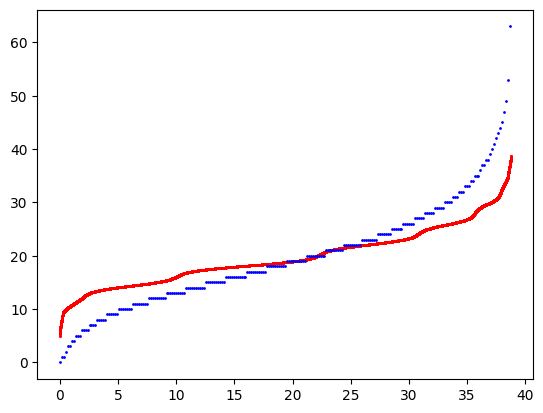

In [243]:
lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)

lr_preds = lr.predict(X_test_clean)

regression_scores(y_test_clean, lr_preds, 'Linear')

print(f'Model intercept: {lr.intercept_}')
print(f'Model coefs: {lr.coef_}')

As we can see, outlier removal has decreased the score of Linear Regression. Let's check other regressors:

Best alpha: 0.9078157234468938
Ridge (alpha=0.9078157234468938) Regression:
 MSE: 78.01019003602353
 MAE: 6.48746070350918
 R^2: 0.24972239076297742

Model intercept: 29.292517287519285
Model coefs: [-8.13131437e+00  5.15920861e+00 -1.21581741e-02 -1.45892869e-03
  2.49024043e-01  3.98915286e-01  1.19390923e-01  1.28739946e+00
 -1.30225601e+00  2.29698218e+00  2.19664150e+00 -2.28119326e+00
 -2.22360881e+00 -1.02315935e-01  3.55231959e-01  2.81976503e-01
 -4.36182066e-01  5.41301688e-02  4.92684753e-02 -5.05278032e-03
  3.79718725e-01 -1.86178534e+00 -2.13444116e+00  2.28604700e+00
  2.18055732e+00 -1.31837444e-02 -3.97133505e-01  6.76340044e-02
  5.10856046e-01 -4.45995473e-02 -5.86453296e-02 -9.60520319e-02
 -5.86612128e-02]


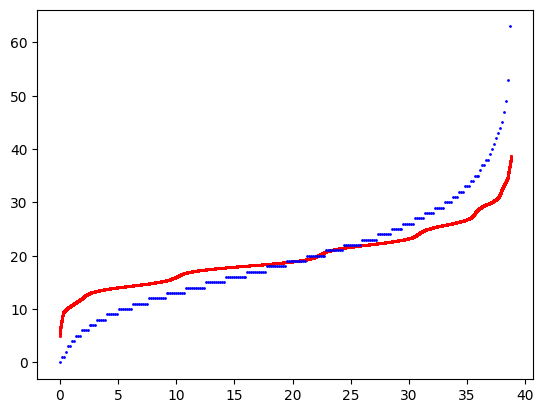

In [244]:
alphas = np.linspace(0.000001, 1, 500)

mses_ridge, maes_ridge, r2s_ridge = [], [], []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train_clean, y_train_clean)
    ridge_preds = ridge.predict(X_test_clean)
    mses_ridge.append(mean_squared_error(y_test_clean, ridge_preds))
    maes_ridge.append(mean_absolute_error(y_test_clean, ridge_preds))
    r2s_ridge.append(r2_score(y_test_clean, ridge_preds))

best_alpha = alphas[np.argmax(r2s_ridge)]

print(f'Best alpha: {best_alpha}')

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_clean, y_train_clean)

ridge_preds = ridge.predict(X_test_clean)

regression_scores(y_test_clean, ridge_preds, f'Ridge (alpha={best_alpha})')

print(f'Model intercept: {ridge.intercept_}')
print(f'Model coefs: {ridge.coef_}')

Best depth: 8
Decision Tree Regression:
 MSE: 76.60916499520633
 MAE: 6.390133004834657
 R^2: 0.26319701141984464



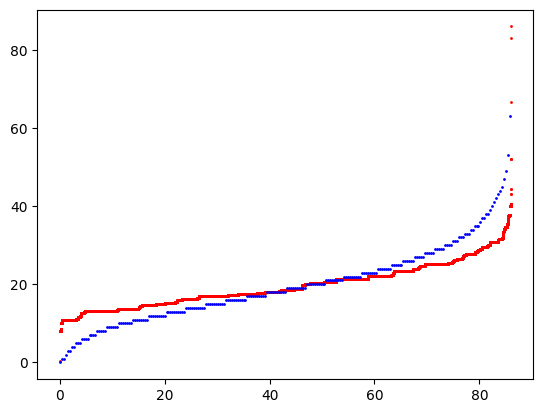

In [245]:
depths = range(2, 25)

mses_dtr, maes_dtr, r2s_dtr = [], [], []

for depth in depths:
    dtr = DecisionTreeRegressor(max_depth=depth).fit(X_train_clean, y_train_clean)
    dtr_preds = dtr.predict(X_test_clean)
    mses_dtr.append(mean_squared_error(y_test_clean, dtr_preds))
    maes_dtr.append(mean_absolute_error(y_test_clean, dtr_preds))
    r2s_dtr.append(r2_score(y_test_clean, dtr_preds))

best_depth = depths[np.argmax(r2s_dtr)]

print(f'Best depth: {best_depth}')

dtr = DecisionTreeRegressor(max_depth=best_depth)
dtr.fit(X_train_clean, y_train_clean)

dtr_preds = dtr.predict(X_test_clean)

regression_scores(y_test_clean, dtr_preds, 'Decision Tree')

In [246]:
X_train_tensor = torch.tensor(X_train_clean.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_clean.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_clean.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_clean.values.reshape(-1, 1), dtype=torch.float32)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

model = RegressionModel(input_size=X_train.shape[1], hidden_size=20)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 25

mse_scores = []
mae_scores = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    model.eval()
    with torch.no_grad():
        nn_outputs = model(X_test_tensor)
        
        mse_scores.append(mean_squared_error(y_test_tensor.numpy(), nn_outputs.numpy()))
        mae_scores.append(mean_absolute_error(y_test_tensor.numpy(), nn_outputs.numpy()))
        r2_scores.append(r2_score(y_test_tensor.numpy(), nn_outputs.numpy()))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}\n MSE: {mse_scores[-1]:.4f}, MAE: {mae_scores[-1]:.4f}, R2: {r2_scores[-1]:.4f}')

Epoch [1/25], Loss: 82.5181
 MSE: 121.8310, MAE: 8.0988, R2: -0.1717
Epoch [2/25], Loss: 66.0947
 MSE: 96.8916, MAE: 7.0962, R2: 0.0681
Epoch [3/25], Loss: 69.9849
 MSE: 81.8682, MAE: 6.5742, R2: 0.2126
Epoch [4/25], Loss: 66.7900
 MSE: 80.3371, MAE: 6.5086, R2: 0.2273
Epoch [5/25], Loss: 67.6767
 MSE: 80.4033, MAE: 6.5351, R2: 0.2267
Epoch [6/25], Loss: 66.4616
 MSE: 79.6433, MAE: 6.4851, R2: 0.2340
Epoch [7/25], Loss: 65.8502
 MSE: 79.7055, MAE: 6.4775, R2: 0.2334
Epoch [8/25], Loss: 64.9957
 MSE: 79.6399, MAE: 6.4679, R2: 0.2340
Epoch [9/25], Loss: 63.9955
 MSE: 80.0536, MAE: 6.4701, R2: 0.2301
Epoch [10/25], Loss: 65.4573
 MSE: 79.7553, MAE: 6.4761, R2: 0.2329
Epoch [11/25], Loss: 62.9969
 MSE: 80.1215, MAE: 6.4626, R2: 0.2294
Epoch [12/25], Loss: 63.3799
 MSE: 80.4834, MAE: 6.4820, R2: 0.2259
Epoch [13/25], Loss: 62.4604
 MSE: 80.4349, MAE: 6.4852, R2: 0.2264
Epoch [14/25], Loss: 62.5584
 MSE: 80.5434, MAE: 6.4734, R2: 0.2254
Epoch [15/25], Loss: 64.6353
 MSE: 80.1893, MAE: 6.4782

Neural Network Regression:
 MSE: 80.01226659783006
 MAE: 6.483966345961814
 R^2: 0.23046704456258948



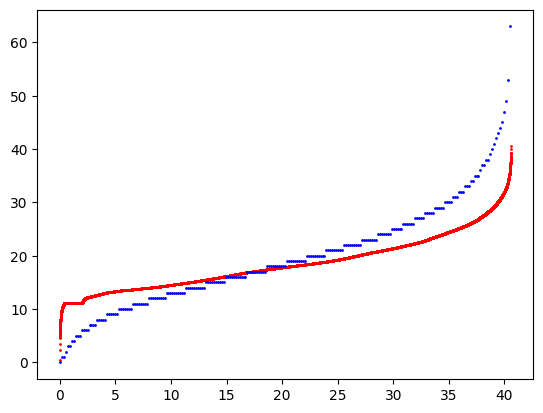

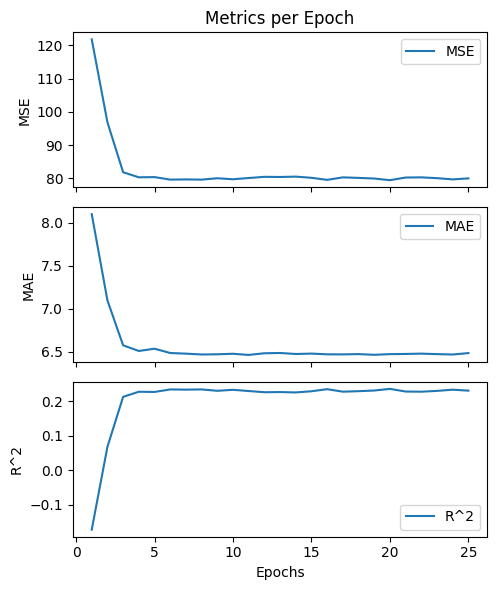

In [247]:
with torch.no_grad():
    nn_preds = model(X_test_tensor)

regression_scores(y_test_clean, nn_preds.numpy().reshape(1, -1)[0], 'Neural Network')

epochs = range(1, len(mse_scores) + 1)

fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)

axes[0].plot(epochs, mse_scores, label='MSE')
axes[0].set_ylabel('MSE')
axes[0].set_title('Metrics per Epoch')
axes[0].legend()

axes[1].plot(epochs, mae_scores, label='MAE')
axes[1].set_ylabel('MAE')
axes[1].legend()

axes[2].plot(epochs, r2_scores, label='R^2')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('R^2')
axes[2].legend()

plt.tight_layout()
plt.show()

In [248]:
cat = CatBoostRegressor()
cat.fit(X_train, y_train)

Learning rate set to 0.107995
0:	learn: 10.7523457	total: 358ms	remaining: 5m 57s
1:	learn: 10.4615637	total: 666ms	remaining: 5m 32s
2:	learn: 10.2256665	total: 936ms	remaining: 5m 10s
3:	learn: 10.0300504	total: 1.17s	remaining: 4m 50s
4:	learn: 9.8707749	total: 1.4s	remaining: 4m 37s
5:	learn: 9.7422315	total: 1.65s	remaining: 4m 33s
6:	learn: 9.6350530	total: 2.04s	remaining: 4m 50s
7:	learn: 9.5509245	total: 2.3s	remaining: 4m 45s
8:	learn: 9.4819186	total: 2.63s	remaining: 4m 49s
9:	learn: 9.4231580	total: 2.83s	remaining: 4m 40s
10:	learn: 9.3724778	total: 3.01s	remaining: 4m 30s
11:	learn: 9.3324601	total: 3.23s	remaining: 4m 26s
12:	learn: 9.2974141	total: 3.57s	remaining: 4m 30s
13:	learn: 9.2690653	total: 4.06s	remaining: 4m 45s
14:	learn: 9.2464235	total: 4.34s	remaining: 4m 44s
15:	learn: 9.2264955	total: 4.59s	remaining: 4m 42s
16:	learn: 9.2110209	total: 4.85s	remaining: 4m 40s
17:	learn: 9.1969511	total: 5.15s	remaining: 4m 40s
18:	learn: 9.1855588	total: 5.38s	remainin

CatBoost Regression:
 MSE: 75.05745906017525
 MAE: 6.327423839771407
 R^2: 0.3493419720191022



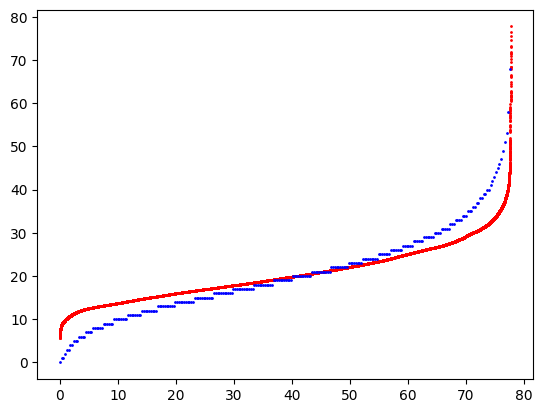

In [249]:
cat_preds = cat.predict(X_test)

regression_scores(y_test, cat_preds, 'CatBoost')

As we can see, IQR outlier removal has worsened the results of our regression models

## Classification task

In [250]:
dfc = df.copy(deep=True)
dfc.drop('actual_preparation_time', axis=1, inplace=True)
potential_outliers_columns = ['planned_prep_time', 'products_count', 'total_price', 'profit']

X_train, X_test = train_test_split(
    dfc.drop('prepared_in_time', axis=1),
    test_size=0.1, shuffle=False)

y_train, y_test = train_test_split(dfc['prepared_in_time'], test_size=0.1, shuffle=False)

X_train.shape, X_test.shape

((463422, 33), (51492, 33))

In [251]:
X_train

,STATUS_ID,planned_prep_time,region_id,store_id,products_count,total_price,profit,oc_is_weekend,osp_is_weekend,oc_month_sin,...,osp_day_sin,osp_day_cos,osp_weekday_sin,osp_weekday_cos,osp_hour_sin,osp_hour_cos,osp_minute_sin,osp_minute_cos,osp_second_sin,osp_second_cos
0,1.0,35.0,0.0,119.0,3.0,40.290,20.1450,0.0,0.0,-0.342020,...,0.998717,-0.050649,0.866025,-0.5,0.000000,1.000000,0.106293,0.994335,0.786552,-0.617525
1,1.0,15.0,8.0,370.0,1.0,31.600,15.8000,0.0,0.0,-0.342020,...,0.998717,-0.050649,0.866025,-0.5,0.000000,1.000000,0.211383,0.977403,0.106293,0.994335
2,1.0,20.0,4.0,667.0,1.0,30.020,6.0040,0.0,0.0,-0.342020,...,0.998717,-0.050649,0.866025,-0.5,0.000000,1.000000,0.106293,0.994335,-0.818303,0.574787
3,1.0,30.0,0.0,695.0,4.0,80.580,40.2900,0.0,0.0,-0.342020,...,0.998717,-0.050649,0.866025,-0.5,0.000000,1.000000,0.874763,0.484551,0.678312,0.734774
4,1.0,25.0,10.0,704.0,3.0,153.418,122.7344,0.0,0.0,-0.342020,...,0.998717,-0.050649,0.866025,-0.5,0.000000,1.000000,0.211383,0.977403,-0.716457,-0.697632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465804,1.0,15.0,11.0,803.0,2.0,33.575,44.5560,0.0,0.0,-0.642788,...,-0.998717,-0.050649,-0.866025,-0.5,-0.519584,0.854419,0.786552,-0.617525,0.000000,1.000000
465805,1.0,35.0,0.0,197.0,2.0,65.570,52.4560,0.0,0.0,-0.642788,...,-0.998717,-0.050649,-0.866025,-0.5,-0.519584,0.854419,0.786552,-0.617525,0.106293,0.994335
465806,1.0,20.0,0.0,84.0,2.0,49.770,24.8850,0.0,0.0,-0.642788,...,-0.998717,-0.050649,-0.866025,-0.5,-0.519584,0.854419,0.638244,-0.769834,-0.921312,0.388824
465807,1.0,25.0,0.0,865.0,2.0,67.150,33.5750,0.0,0.0,-0.642788,...,-0.998717,-0.050649,-0.866025,-0.5,-0.519584,0.854419,0.364161,-0.931336,-0.752571,0.658511


Let's remove the outliers using IQR. It is said that the value is outlier if it lays before Q1 - 1.5 IQR or beyond Q3 + 1.5 IQR, where IQR = Q3 - Q1. We would find lower and upper bounds for training set and use this bounds on both training and testing sets

In [252]:
Q1 = X_train[potential_outliers_columns].quantile(0.25)
Q3 = X_train[potential_outliers_columns].quantile(0.75)
IQR = Q3 - Q1

In [253]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [254]:
outliers_train = ((X_train[potential_outliers_columns] < lower_bound) | (X_train[potential_outliers_columns] > upper_bound)).any(axis=1)

X_train_clean = X_train[~outliers_train]
y_train_clean = y_train[~outliers_train]

In [255]:
outliers_test = ((X_test[potential_outliers_columns] < lower_bound) | (X_test[potential_outliers_columns] > upper_bound)).any(axis=1)

X_test_clean = X_test[~outliers_test]
y_test_clean = y_test[~outliers_test]

In [256]:
X_train.shape, X_train_clean.shape

((463422, 33), (413624, 33))

In [257]:
print(f'After IQR outlier detection and removal remains {X_train_clean.shape[0]} rows in X_train, or {X_train_clean.shape[0] / X_train.shape[0] * 100:.4f}% of original training data')
print(f'After IQR outlier detection and removal remains {X_test_clean.shape[0]} rows in X_test, or {X_test_clean.shape[0] / X_test.shape[0] * 100:.4f}% of original testing data')

After IQR outlier detection and removal remains 413624 rows in X_train, or 89.2543% of original training data
After IQR outlier detection and removal remains 45674 rows in X_test, or 88.7012% of original testing data


Now let's scale the data

In [258]:
scaler = StandardScaler()
scaler.fit(X_train_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']])
X_train_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_train_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']])
X_test_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_test_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']])

/tmp/ipykernel_3884/1685308847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_train_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']])
/tmp/ipykernel_3884/1685308847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_clean[['planned_prep_time', 'products_count', 'total_price', 'profit']] = scaler.transform(X_test_clean[['planned_prep_time', 'products_count', 'total_price', 

And check for target imbalance

In [259]:
for dataset in ['train', 'test']:
    class1 = eval(f'y_{dataset}_clean').value_counts()[0]
    class1_name = eval(f'y_{dataset}_clean').value_counts().index[0]
    class2 = eval(f'y_{dataset}_clean').value_counts()[1]
    class2_name = eval(f'y_{dataset}_clean').value_counts().index[1]
    total = eval(f'y_{dataset}_clean').count()
    print(f'Proportions of target classes in {dataset} dataset: \n {class1 / total * 100}% for class {class1_name} \n {class2 / total * 100}% for class {class2_name} \n')

Proportions of target classes in train dataset: 
 52.76386283194399% for class 0.0 
 47.23613716805601% for class 1.0 

Proportions of target classes in test dataset: 
 52.89661514209397% for class 0.0 
 47.10338485790603% for class 1.0 



Since it's pretty balanced, no further balancing required

In [260]:
def classification_scores(y_true, y_pred, model_name):
    print(f'{model_name} Classifier:')
    print(f' Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f' Precision: {precision_score(y_true, y_pred)}')
    print(f' Recall: {recall_score(y_true, y_pred)}')
    print(f' F1 score: {f1_score(y_true, y_pred)}')
    print(f' AUC-ROC: {roc_auc_score(y_true, y_pred)}')
    print('Classification report:')
    print(classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=None).plot()
    plt.show()

In [262]:
Cs = np.linspace(0.001, 1, 25)

accuracies = []
precisions = []
recalls = []
f1s = []
auc_rocs = []

for c in Cs:
    lc = LogisticRegression(random_state=42, C=c)
    lc.fit(X_train_clean, y_train_clean)
    lc_preds = lc.predict(X_test_clean)
    accuracies.append(accuracy_score(y_test_clean, lc_preds))
    precisions.append(precision_score(y_test_clean, lc_preds))
    recalls.append(recall_score(y_test_clean, lc_preds))
    f1s.append(f1_score(y_test_clean, lc_preds))
    auc_rocs.append(roc_auc_score(y_test_clean, lc_preds))
    if auc_rocs[-1] > best_auc_roc:
        best_c = c
        best_auc_roc = auc_rocs[-1]

best_c = Cs[np.argmax(auc_rocs)]

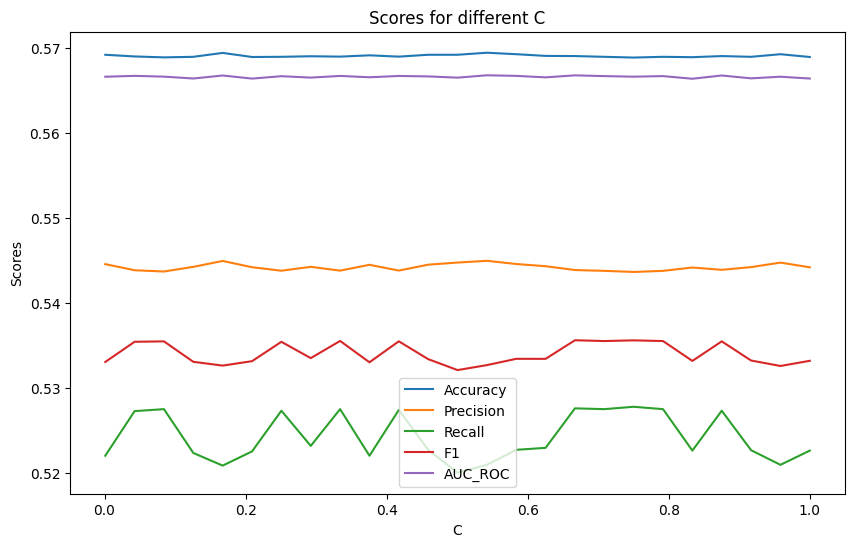

In [263]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(Cs, accuracies, label='Accuracy')
ax.plot(Cs, precisions, label='Precision')
ax.plot(Cs, recalls, label='Recall')
ax.plot(Cs, f1s, label='F1')
ax.plot(Cs, auc_rocs, label='AUC_ROC')

ax.set_xlabel('C')
ax.set_ylabel('Scores')
ax.set_title('Scores for different C')

plt.legend()
plt.show()

Best C: 0.5421250000000001
LogisticRegression Classifier:
 Accuracy: 0.5694705959626921
 Precision: 0.5449771467470582
 Recall: 0.5209630937993864
 F1 score: 0.5326996197718631
 AUC-ROC: 0.5668143283566469
Classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60     24160
         1.0       0.54      0.52      0.53     21514

    accuracy                           0.57     45674
   macro avg       0.57      0.57      0.57     45674
weighted avg       0.57      0.57      0.57     45674



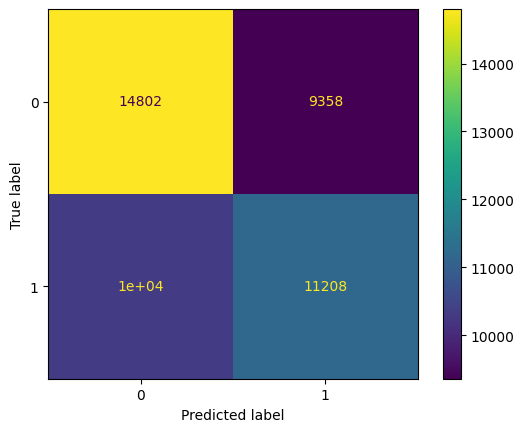

In [264]:
print(f'Best C: {best_c}')

lc = LogisticRegression(random_state=42, C=best_c, max_iter=400)
lc.fit(X_train_clean, y_train_clean)
lc_preds = lc.predict(X_test_clean)

classification_scores(y_test_clean, lc_preds, 'LogisticRegression')

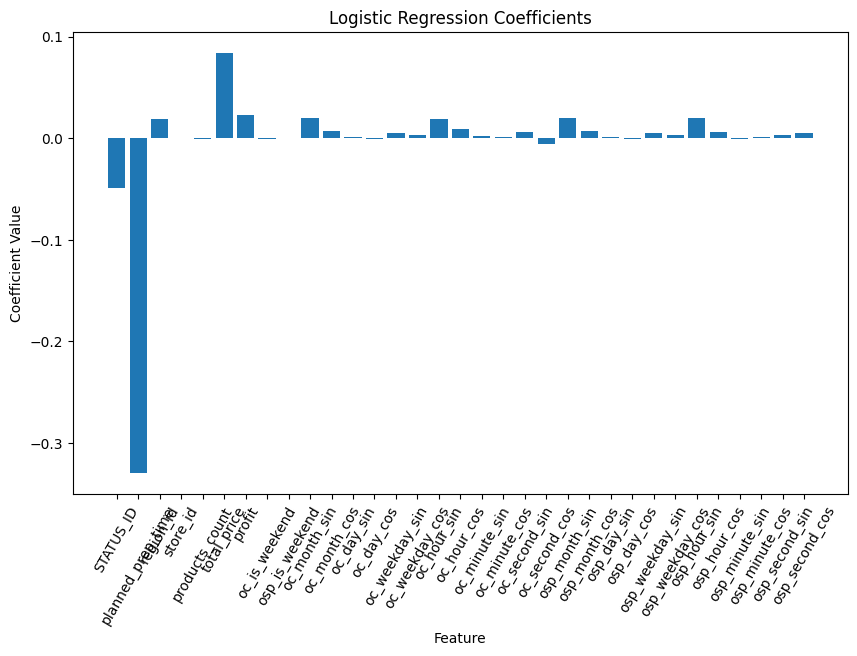

In [265]:
plt.figure(figsize=(10, 6))
plt.bar(X_train_clean.columns, lc.coef_[0])
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=60)
# plt.tight_layout()
plt.show()

In [266]:
for feature, coef in zip(X_train_clean.columns, lc.coef_[0]):
    print(f'{feature}: {coef}')

STATUS_ID: -0.04918403049371826
planned_prep_time: -0.3296235193966393
region_id: 0.018885787537256785
store_id: -7.850955781322087e-05
products_count: -0.0006585854552864122
total_price: 0.08388818686804501
profit: 0.023119318404373566
oc_is_weekend: -0.0004496612555392543
osp_is_weekend: -3.239204103539283e-05
oc_month_sin: 0.01988556209444038
oc_month_cos: 0.007272041812967104
oc_day_sin: 0.001735668908804427
oc_day_cos: -0.0007772764433698456
oc_weekday_sin: 0.005201202111277399
oc_weekday_cos: 0.003144366660646776
oc_hour_sin: 0.018756185535424894
oc_hour_cos: 0.009357786161725517
oc_minute_sin: 0.002781941970585131
oc_minute_cos: 0.001185181763787143
oc_second_sin: 0.0060404886501547244
oc_second_cos: -0.005913928199100796
osp_month_sin: 0.019847952831853265
osp_month_cos: 0.007286516515389373
osp_day_sin: 0.001739615478624437
osp_day_cos: -0.0007971726167683796
osp_weekday_sin: 0.00502158481285313
osp_weekday_cos: 0.0035521340601433102
osp_hour_sin: 0.02035539242197189
osp_hour_

Let's see how important different features are

In [267]:
pd.DataFrame({'Importance': np.abs(lc.coef_[0]) * np.std(X_train_clean, axis=0)}).sort_values('Importance', ascending=False)

,Importance
planned_prep_time,0.329624
total_price,0.083888
region_id,0.079858
store_id,0.027513
profit,0.023119
osp_hour_sin,0.009690
oc_hour_sin,0.008950
oc_hour_cos,0.007105
oc_month_sin,0.004839
osp_month_sin,0.004829


In [268]:
cbc = CatBoostClassifier()
cbc.fit(X_train_clean, y_train_clean)
cbc_preds = cbc.predict(X_test_clean)

Learning rate set to 0.134966
0:	learn: 0.6896193	total: 306ms	remaining: 5m 5s
1:	learn: 0.6871662	total: 548ms	remaining: 4m 33s
2:	learn: 0.6850574	total: 829ms	remaining: 4m 35s
3:	learn: 0.6835102	total: 1.06s	remaining: 4m 24s
4:	learn: 0.6823653	total: 1.32s	remaining: 4m 22s
5:	learn: 0.6813980	total: 1.55s	remaining: 4m 16s
6:	learn: 0.6806646	total: 1.76s	remaining: 4m 9s
7:	learn: 0.6801268	total: 1.98s	remaining: 4m 5s
8:	learn: 0.6796686	total: 2.3s	remaining: 4m 13s
9:	learn: 0.6792429	total: 2.56s	remaining: 4m 13s
10:	learn: 0.6789429	total: 2.78s	remaining: 4m 10s
11:	learn: 0.6786661	total: 3.04s	remaining: 4m 10s
12:	learn: 0.6784349	total: 3.27s	remaining: 4m 8s
13:	learn: 0.6782377	total: 3.53s	remaining: 4m 8s
14:	learn: 0.6780859	total: 3.76s	remaining: 4m 6s
15:	learn: 0.6778703	total: 4.1s	remaining: 4m 11s
16:	learn: 0.6777469	total: 4.35s	remaining: 4m 11s
17:	learn: 0.6775937	total: 4.55s	remaining: 4m 8s
18:	learn: 0.6774590	total: 4.72s	remaining: 4m 3s
19

CatBoost Classifier:
 Accuracy: 0.5790165082979376
 Precision: 0.5586815894855734
 Recall: 0.5058101701217812
 F1 score: 0.5309328649492584
 AUC-ROC: 0.5750077340675132
Classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.64      0.62     24160
         1.0       0.56      0.51      0.53     21514

    accuracy                           0.58     45674
   macro avg       0.58      0.58      0.57     45674
weighted avg       0.58      0.58      0.58     45674



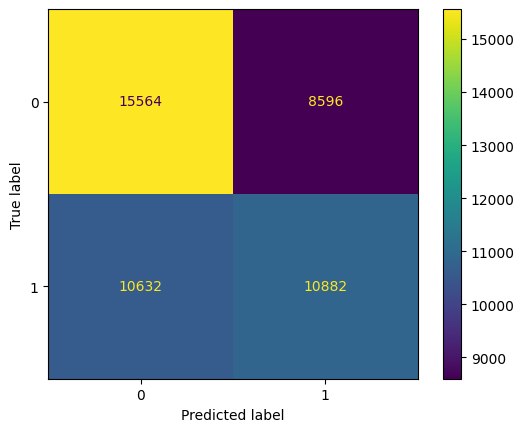

In [269]:
classification_scores(y_test_clean, cbc_preds, 'CatBoost')

In [270]:
X_train_class_tensor = torch.tensor(X_train_clean.values, dtype=torch.float32)
y_train_class_tensor = torch.tensor(y_train_clean.values.reshape(-1, 1), dtype=torch.float32)
X_test_class_tensor = torch.tensor(X_test_clean.values, dtype=torch.float32)
y_test_class_tensor = torch.tensor(y_test_clean.values.reshape(-1, 1), dtype=torch.float32)

batch_size = 32

train_dataset_class = TensorDataset(X_train_class_tensor, y_train_class_tensor)
train_loader_class = DataLoader(train_dataset_class, batch_size=batch_size, shuffle=False, drop_last=True)

In [271]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out

In [272]:
class_model = ClassificationModel(input_size=X_train_clean.shape[1], hidden_size=20)

criterion = nn.BCELoss()
optimizer = Adam(class_model.parameters(), lr=0.001)

In [273]:
num_epochs = 25

accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

for epoch in range(num_epochs):
    class_model.train()
    for inputs, targets in train_loader_class:
        outputs = class_model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    class_model.eval()
    with torch.no_grad():
        nn_outputs = class_model(X_test_class_tensor)
        nn_outputs = [1 if x >= 0.5 else 0 for x in nn_outputs.numpy()]
        
        accuracies.append(accuracy_score(y_test_class_tensor.numpy(), nn_outputs))
        precisions.append(precision_score(y_test_class_tensor.numpy(), nn_outputs))
        recalls.append(recall_score(y_test_class_tensor.numpy(), nn_outputs))
        f1s.append(f1_score(y_test_class_tensor.numpy(), nn_outputs))
        aucs.append(roc_auc_score(y_test_class_tensor.numpy(), nn_outputs))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f' Accuracy: {accuracies[-1]:.4f}, Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1 score: {f1s[-1]:.4f}, AUC-ROC: {aucs[-1]:.4f}')

Epoch [1/25], Loss: 0.6446
 Accuracy: 0.5683, Precision: 0.5421, Recall: 0.5375, F1 score: 0.5398, AUC-ROC: 0.5666
Epoch [2/25], Loss: 0.6442
 Accuracy: 0.5687, Precision: 0.5428, Recall: 0.5344, F1 score: 0.5386, AUC-ROC: 0.5668
Epoch [3/25], Loss: 0.6437
 Accuracy: 0.5710, Precision: 0.5509, Recall: 0.4822, F1 score: 0.5143, AUC-ROC: 0.5661
Epoch [4/25], Loss: 0.6365
 Accuracy: 0.5651, Precision: 0.5352, Recall: 0.5823, F1 score: 0.5578, AUC-ROC: 0.5660
Epoch [5/25], Loss: 0.6395
 Accuracy: 0.5685, Precision: 0.5425, Recall: 0.5351, F1 score: 0.5388, AUC-ROC: 0.5667
Epoch [6/25], Loss: 0.6487
 Accuracy: 0.5706, Precision: 0.5462, Recall: 0.5221, F1 score: 0.5339, AUC-ROC: 0.5679
Epoch [7/25], Loss: 0.6393
 Accuracy: 0.5663, Precision: 0.5380, Recall: 0.5605, F1 score: 0.5490, AUC-ROC: 0.5660
Epoch [8/25], Loss: 0.6410
 Accuracy: 0.5680, Precision: 0.5418, Recall: 0.5367, F1 score: 0.5392, AUC-ROC: 0.5663
Epoch [9/25], Loss: 0.6405
 Accuracy: 0.5694, Precision: 0.5454, Recall: 0.5159,

Neural Network Classifier:
 Accuracy: 0.5697990103778955
 Precision: 0.544171285112027
 Recall: 0.5339778748721763
 F1 score: 0.5390263929618769
 AUC-ROC: 0.5678374473698629
Classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.60      0.60     24160
         1.0       0.54      0.53      0.54     21514

    accuracy                           0.57     45674
   macro avg       0.57      0.57      0.57     45674
weighted avg       0.57      0.57      0.57     45674



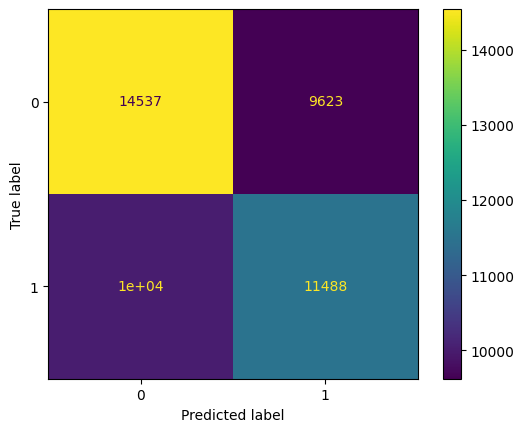

In [274]:
with torch.no_grad():
    nn_preds = class_model(X_test_class_tensor)

classification_scores(y_test_clean, [1 if x >= 0.5 else 0 for x in nn_preds.numpy()], 'Neural Network')

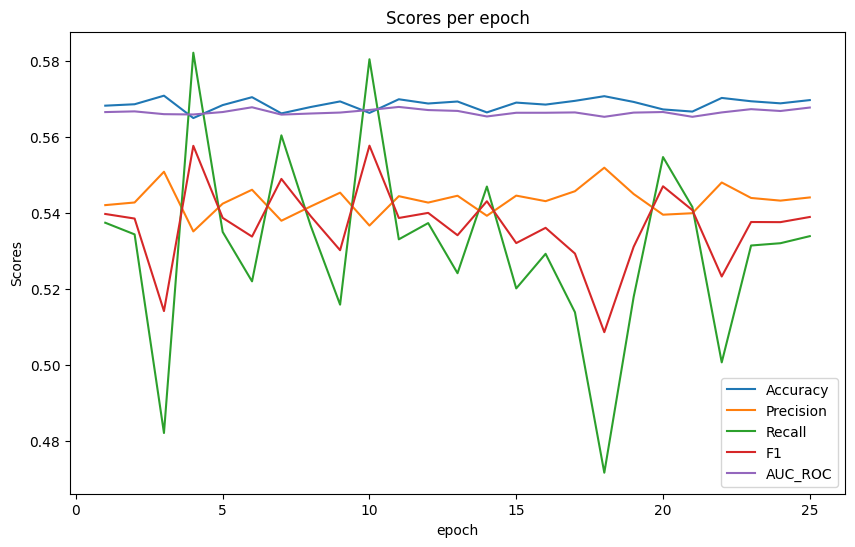

In [275]:
fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, num_epochs + 1)

ax.plot(epochs, accuracies, label='Accuracy')
ax.plot(epochs, precisions, label='Precision')
ax.plot(epochs, recalls, label='Recall')
ax.plot(epochs, f1s, label='F1')
ax.plot(epochs, aucs, label='AUC_ROC')

ax.set_xlabel('epoch')
ax.set_ylabel('Scores')
ax.set_title('Scores per epoch')

plt.legend()
plt.show()